In [11]:
import os
import numpy as np
import pandas as pd
import random
import pysindy as ps
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error

In [3]:
class synthetic_data(object):
    """
    The class provides the following:
    1. generate_data()
    2. get_data()
    """
    def __init__(self, data_path,timeHorizon, numOfInitCond):
        self.data_path = data_path # Need to be adjusted if we enlarge the proof of concept.   
        self.timeHorizon = timeHorizon
        self.numOfInitCond = numOfInitCond

    def generate_data(self, compiled_file): # Complied file need to be change in other args... e.g., Python class or .py file.
        self.compiled_file = compiled_file

        angles = np.linspace(0, 2*np.pi, self.numOfInitCond)[:-1] # To prevent the duplicated initial condtions, exclude the last initial condition.

        # Calculate x and y coordinates using trigonometric functions
        for rad in range(1,6): # Control the radius.. In the future, let this become an argument for the genereate data function.
            x = np.round(rad*np.cos(angles),3)
            y = np.round(rad*np.sin(angles),3)
            for x_coord, y_coord in zip(x,y):
                if x_coord<1e-10 or y_coord<1e-10: # For numerical stability
                    pass
                x_coord, y_coord = np.round(x_coord,3), np.round(y_coord,3)
                os.system(f'python ./{self.compiled_file} {x_coord} {y_coord} -T {self.timeHorizon} -o {self.data_path}/{x_coord}_{y_coord}.csv') # if possible, change the data format to .pickle
        
        print(f"Synthetic data with dynamics {self.compiled_file} generated.")
    
    def get_data(self, ratio, seed):
        list_of_data = os.listdir(self.data_path)
        random.Random(seed).shuffle(list_of_data)

        num_of_train = int(len(list_of_data) * ratio)
        train_list = list_of_data[:num_of_train]
        test_list = list_of_data[num_of_train:]

        train_data = [] 
        for filename in [file for file in train_list if file.split('.')[-1] == 'csv']:
            temp_data = pd.read_csv(os.path.join(self.data_path,filename),index_col='t').values #
            train_data.append(temp_data)
        train_data = np.array(train_data)

        test_data = []
        for filename in [file for file in test_list if file.split('.')[-1] == 'csv']:
            temp_data = pd.read_csv(os.path.join(self.data_path,filename),index_col='t').values #
            test_data.append(temp_data)
        test_data = np.array(test_data)

        self.train_list = train_list
        self.test_list = test_list

        print(f'train data shape {train_data.shape}') # the number of different initial condtions, the number of datapoints over time, state
        print(f'test data shape {test_data.shape}')

        return train_data, test_data


In [23]:
test1 = synthetic_data(data_path='./data/koopman0/', timeHorizon=2, numOfInitCond=10) # Generate the synthetic data based on the given arguments.
# test1.generate_data(compiled_file='koopman0.pyc')
train_data, test_data = test1.get_data(ratio=1, seed=4) # Bring train and test data with fixed seed. This is not necessary till now.

train data shape (45, 201, 2)
test data shape (0,)


Here, system Identification of Nonlinear Dynamics (SINDy) is leveraged to find the underlying dynamics of koopman0.pyc.
The method is introduced by Brunton et al. [1], and we can interpret the approach as a sparse regression with a large augmented state as independent variables and differentiated observed states as dependent variables.

To elaborate the method, we start with measurements of state variables $\mathbf{x}(t)$ at different points in time. Suppose our state variables is represented as $m$-dimensional vector, and we have $n$ measurements. In formal way, we denote the measurement at time $t_{i}$ as ${\mathbf{x}}^{T}(t_{i}) = [x_{1}(t_{i}), x_{2}(t_{i}), \cdots, x_{m}(t_{i}) ]$.
The full data matrix is $$\mathbf{X} = \begin{bmatrix} {\mathbf{x}}^{T}(t_{1}) \\ {\mathbf{x}}^{T}(t_{2}) \\ \vdots \\ {\mathbf{x}}^{T}(t_{n}) \\ \end{bmatrix}$$. Furthermore, by either estimating numerical differentiation or measure the derivative itself directly, the derivative is measured. At time $t_{i}$, the derivative is denoted as ${\dot{\mathbf{x}}}(t_{i})$. The full matrix of derivatives is $$\mathbf{\dot{X}} = \begin{bmatrix} {\dot{\mathbf{x}}}^{T}(t_{1}) \\ {\dot{\mathbf{x}}}^{T}(t_{2}) \\ \vdots \\ {\dot{\mathbf{x}}}^{T}(t_{n}) \end{bmatrix}$$. 
Next, we build a dictionary $\Theta(\bold{X})$ consisting of candidate non-linear functions of the columns of $\mathbf{X}$.
For example, $\Theta(\mathbf{X})$ may consist of constant, polynomial, and trigonometric terms:
$$
\Theta(\mathbf{X})=\left[\begin{array}{cccccccc}
\mid & \mid & \mid & \mid & & \mid & \mid & \mid \\
1 & \mathbf{X} & \mathbf{X}^{P_2} & \mathbf{X}^{P_3} & \cdots & \sin (\mathbf{X}) & \cos (\mathbf{X}) & \cdots \\
\mid & \mid & \mid & \mid & & \mid & \mid &
\end{array}\right] .
$$
In [1], higher polynomials are denoted as $\mathbf{X}^{P_2}, \mathbf{X}^{P_3}$, etc., where $\mathbf{X}^{P_2}$ denotes the 2nd order polynomial augmentation in the state $\mathbf{x}$ :
$$
\mathbf{X}^{P_2}=\left[\begin{array}{cccccc}
x_1^2\left(t_1\right) & x_1\left(t_1\right) x_2\left(t_1\right) & \cdots & x_2^2\left(t_1\right) & \cdots & x_n^2\left(t_1\right) \\
x_1^2\left(t_2\right) & x_1\left(t_2\right) x_2\left(t_2\right) & \cdots & x_2^2\left(t_2\right) & \cdots & x_n^2\left(t_2\right) \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
x_1^2\left(t_m\right) & x_1\left(t_m\right) x_2\left(t_m\right) & \cdots & x_2^2\left(t_m\right) & \cdots & x_n^2\left(t_m\right)
\end{array}\right]
$$

As you have already noticed, main assumption of SINDy is that the vector-valued function $\mathbf{f}$ of a dynamical systems of the form
$$
{\dot{\mathbf{x}}}(t) =\mathbf{f}(\mathbf{x}(t))
$$
can be fully captured by the linear combination of candidate non-linear functions in the dictionary $\Theta(\bold{X})$.

Now, we set up a sparse regression problem to determine the which nonlinearities are active:
$$
\dot{\mathbf{X}}=\Theta(\mathbf{X}) \Xi
$$
where $\Xi = [\xi_1, \xi_2, \cdots ,\xi_m ]$. Each column $\xi_k$ of $\Xi$ is a sparse vector of coefficients determining which terms are active in the righthand side for one of the row equations ${\dot{\mathbf{x}}}(t) =\mathbf{f}(\mathbf{x}(t))$.



References
-   [1] Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz. Discovering governing equations from data by sparse identification of nonlinear dynamical systems. Proceedings of the National Academy of Sciences 113.15 (2016): 3932-3937.

\begin{equation} \begin{pmatrix} \dot x_1(t) \\ \dot x_2(t) \end{pmatrix} = \begin{pmatrix} \alpha^{(0)}_1 \\ \alpha^{(2)}_1 \end{pmatrix} + \begin{pmatrix} \alpha^{(1)}_{1,1} & \alpha^{(1)}_{1,2} \\ \alpha^{(1)}_{2,1} & \alpha^{(1)}_{2,2}\end{pmatrix} \begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix} + \begin{pmatrix} \alpha^{(2)}_{1,2,0} & \alpha^{(2)}_{1,1,1} & \alpha^{(2)}_{1,0,2} \\ \alpha^{(2)}_{2,2,0} & \alpha^{(2)}_{2,1,1} & \alpha^{(2)}_{2,0,2}\end{pmatrix} \begin{pmatrix} x_1^2(t) \\ x_1(t)x_2(t) \\ x_2^2(t)\end{pmatrix} \cdots \end{equation}

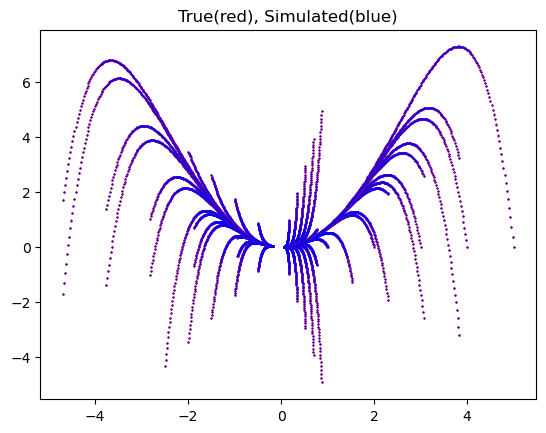

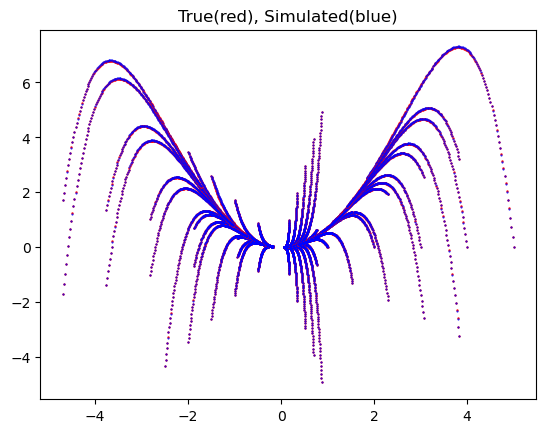

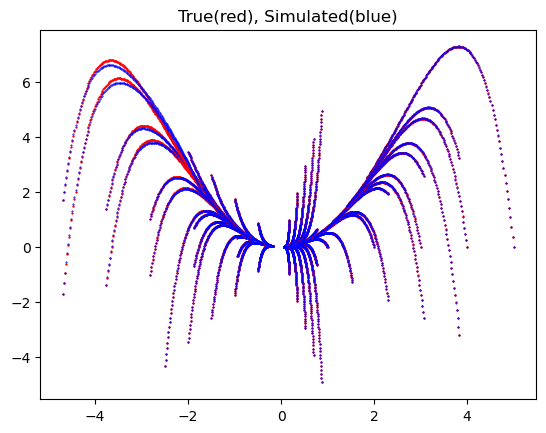

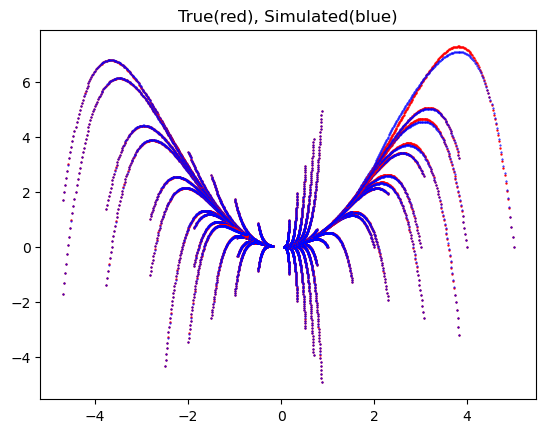

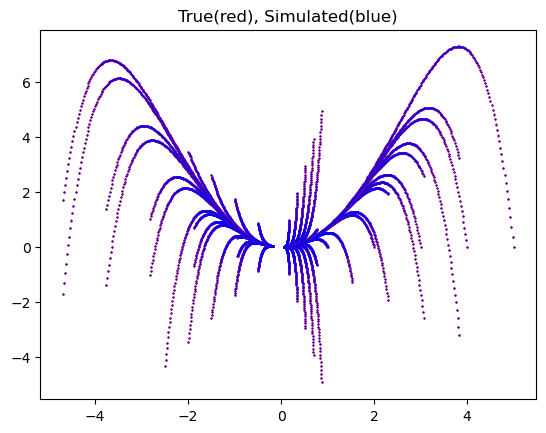

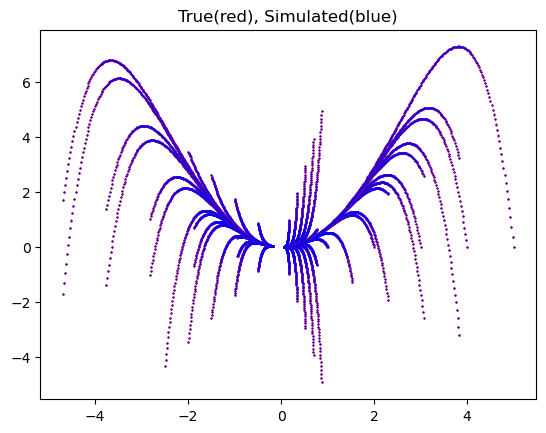

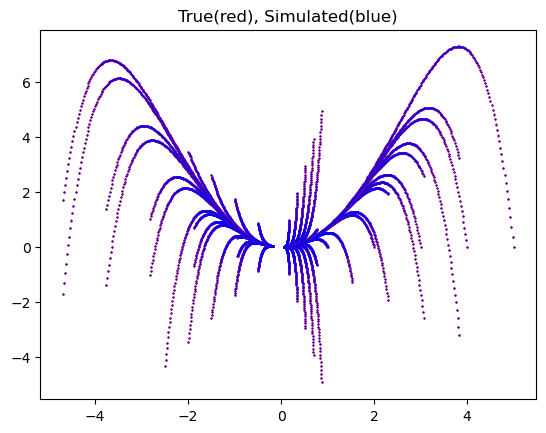

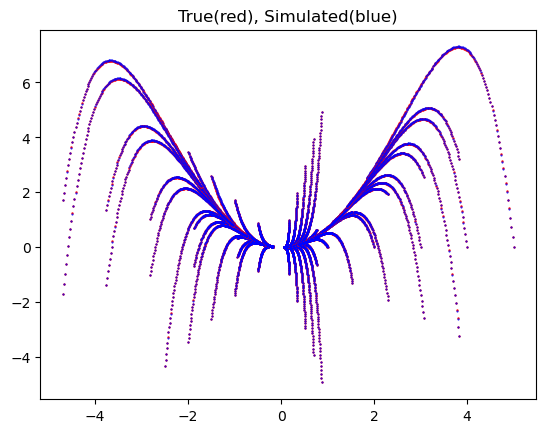

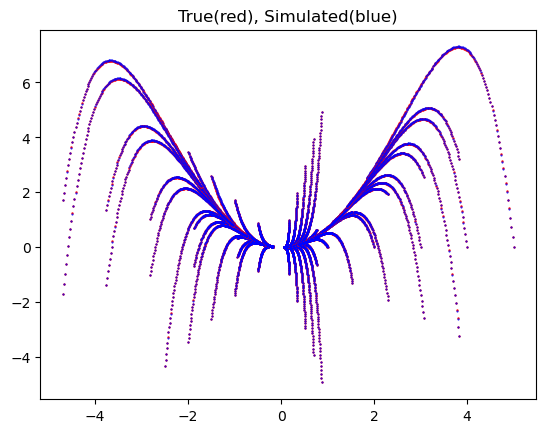

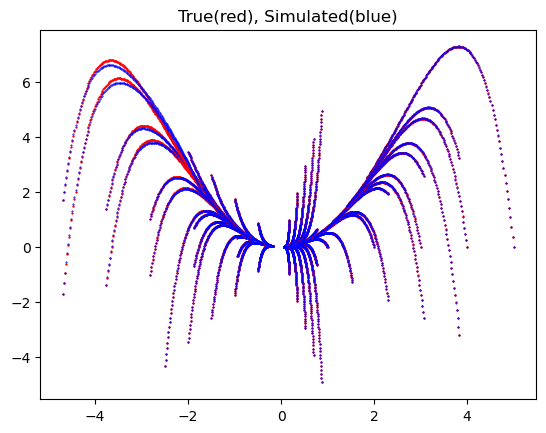

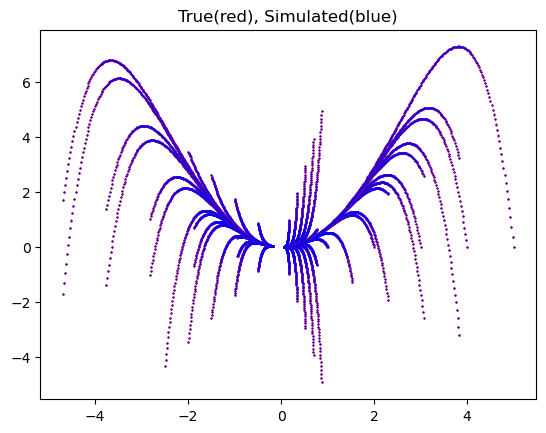

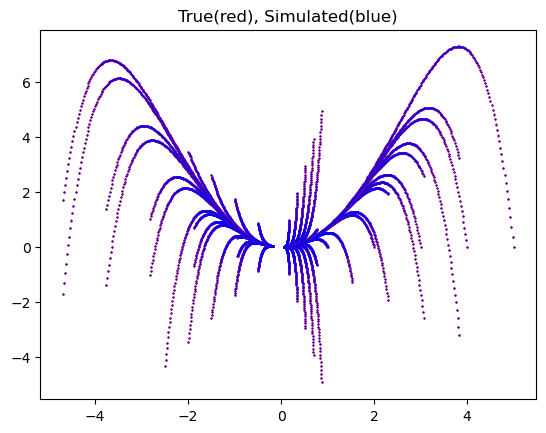

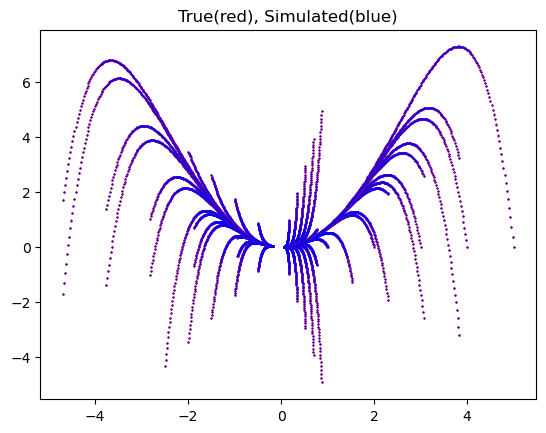

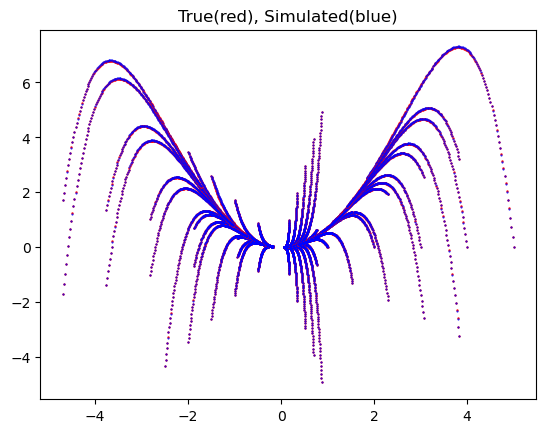

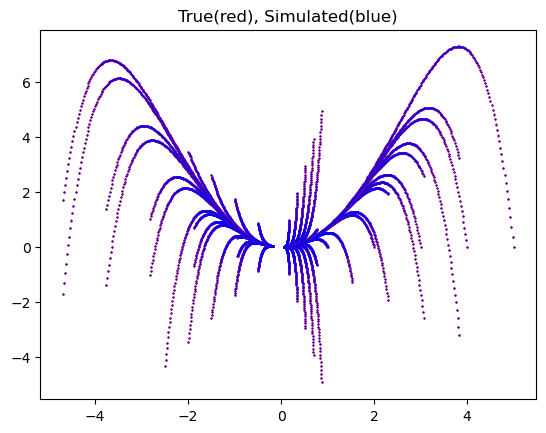

(x)' = -0.501 x
(y)' = -0.001 x + -3.043 y + 1.532 x^2 + -0.007 y^2
['x0', 'x1', 'x0^2', 'x1^2']
Best RMSE: 0.00013880443369245746


In [31]:
# Set of candidate functions
library_functions = [lambda x: x**2,
                     lambda x: x**3,
                     lambda x: np.exp(x),
                     lambda x: np.exp(-x)]

# Set of candidate functions' names
library_functions_names = [lambda x: f'{x}^2',
                           lambda x: f'{x}^3',
                           lambda x: f'e^{x}',
                           lambda x: f'e^-{x}']

best_rms = 10**8 # Very large RMSE
best_avg_rms = 10**8 # Very large RMSE
for L in range(1, len(library_functions) + 1): # Varying number of choice
    for subset in itertools.combinations(zip(library_functions,library_functions_names), L): # For all combination of functions
        custom_lib = ps.CustomLibrary(library_functions=[subset[0][0]], # functions
                            function_names=[subset[0][1]] # names
                            )
        general_lib = ps.GeneralizedLibrary(
            [ps.IdentityLibrary(), custom_lib] # Build general library with states themselves plus the selected candidate functions.
        )
        rmse_list = []
        for data in train_data: # For each initial condtion
            input_form = pd.DataFrame(data,index=np.linspace(0,test1.timeHorizon,1+(test1.timeHorizon*100)), columns=['x','y'])
            model = ps.SINDy(
                differentiation_method=ps.FiniteDifference(order=2), # First order (forward difference) or second order (centered difference) finite difference methods.
                feature_library=general_lib, # our custom library
                optimizer=ps.STLSQ(threshold=0.1), # Sequentially-Thresholded Least-Squares algorithm
                feature_names=["x", "y"]
            )
            model.fit(input_form, t=np.linspace(0, 2, 201))

            plt.scatter(x=data[:,0],y=data[:,1],label='simul',s=0.5,color='red')

            x_sim = model.simulate(input_form.values[0,:], np.linspace(0, 2, 201))
            plt.scatter(x=x_sim[:,0],y=x_sim[:,1],label='simul',s=0.2,color='blue')
            
            rms = mean_squared_error(input_form, x_sim, squared=False)
            rmse_list.append(rms)
            # Keep the best model for each observable set but will be saved when we verify the average RMSE for all initial conditions.
            if rms <= best_rms:
                candidate_model = model
                
        avg_rms = np.average(np.array(rmse_list))
        if avg_rms <= best_avg_rms:
            best_avg_rms = avg_rms
            best_observables = general_lib
            best_model = candidate_model
        plt.title('True(red), Simulated(blue)')
        plt.show()

best_model.print()
print(best_observables.get_feature_names())
print(f'Best RMSE: {best_avg_rms}')